# Forecasting

## Methods

- Last Observed Value
- Simple Average
- Moving Average
- Holt's Linear Trend
- Previous Cycle

**Tomorrow**
- FB Prophet

**Appendix (or Google)**
- ARIMA (ARIMAX)
- Holt Winters
- Exponential Smoothing

---
- Objetive: Build forecasting models to predict number of items sold and total dollars sold.

## Wrangle

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

from sklearn.metrics import mean_squared_error

from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import acquire as ac
import prepare as pr

### Acquire

In [2]:
df = ac.get_sales()
df.head()

,sale_amount,sale_date,sale_id,item_brand,item_id,item_name,item_price,item_upc12,item_upc14,store_address,store_city,store_id,store_state,store_zipcode
0,13.0,"Tue, 01 Jan 2013 00:00:00 GMT",1,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
1,11.0,"Wed, 02 Jan 2013 00:00:00 GMT",2,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
2,14.0,"Thu, 03 Jan 2013 00:00:00 GMT",3,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
3,13.0,"Fri, 04 Jan 2013 00:00:00 GMT",4,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253
4,10.0,"Sat, 05 Jan 2013 00:00:00 GMT",5,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253


### Prepare

In [3]:
df = df.assign(ds = pd.to_datetime(df.sale_date)).\
    sort_values("ds").\
    assign(dollars_sold = df.sale_amount * df.item_price).\
    assign(items_sold = df.sale_amount).\
    groupby(["ds"])[["dollars_sold", "items_sold"]].sum().\
    reset_index().set_index("ds")

## Split

In [4]:
df

,dollars_sold,items_sold
ds,,
2013-01-01 00:00:00+00:00,73844.01,13696.0
2013-01-02 00:00:00+00:00,73570.58,13678.0
2013-01-03 00:00:00+00:00,78169.48,14488.0
2013-01-04 00:00:00+00:00,84467.73,15677.0
2013-01-05 00:00:00+00:00,87621.85,16237.0
...,...,...
2017-12-27 00:00:00+00:00,109151.15,20378.0
2017-12-28 00:00:00+00:00,117377.49,21885.0
2017-12-29 00:00:00+00:00,126541.84,23535.0


In [5]:
train_size = round(int(len(df)) * .66)
test_size = int(len(df) - train_size)

train = df[:train_size]
test = df[train_size:]

train

,dollars_sold,items_sold
ds,,
2013-01-01 00:00:00+00:00,73844.01,13696.0
2013-01-02 00:00:00+00:00,73570.58,13678.0
2013-01-03 00:00:00+00:00,78169.48,14488.0
2013-01-04 00:00:00+00:00,84467.73,15677.0
2013-01-05 00:00:00+00:00,87621.85,16237.0
...,...,...
2016-04-15 00:00:00+00:00,170008.40,31445.0
2016-04-16 00:00:00+00:00,178538.37,33306.0
2016-04-17 00:00:00+00:00,191367.09,35747.0


In [6]:
test

,dollars_sold,items_sold
ds,,
2016-04-20 00:00:00+00:00,148032.83,27627.0
2016-04-21 00:00:00+00:00,158310.20,29403.0
2016-04-22 00:00:00+00:00,170256.17,31583.0
2016-04-23 00:00:00+00:00,178714.14,33316.0
2016-04-24 00:00:00+00:00,191863.49,35576.0
...,...,...
2017-12-27 00:00:00+00:00,109151.15,20378.0
2017-12-28 00:00:00+00:00,117377.49,21885.0
2017-12-29 00:00:00+00:00,126541.84,23535.0


**Verify Splits**

In [7]:
print(len(train) + len(test) == len(df))
print(df.head(1) == train.head(1))

True
                           dollars_sold  items_sold
ds                                                 
2013-01-01 00:00:00+00:00          True        True


## Forecasting
### Last Observed Value
**Make Predictions**

In [8]:
# items sold
items = train["items_sold"][-1:][0]
items

27752.0

In [9]:
# dollars
dollars = round(train["dollars_sold"][-1:][0], 2)
dollars

149645.67

In [10]:
yhat_df = pd.DataFrame({
    "items_sold": [items],
    "dollars_sold": [dollars]
}, index=test.index)

yhat_df.head()

,items_sold,dollars_sold
ds,,
2016-04-20 00:00:00+00:00,27752.0,149645.67
2016-04-21 00:00:00+00:00,27752.0,149645.67
2016-04-22 00:00:00+00:00,27752.0,149645.67
2016-04-23 00:00:00+00:00,27752.0,149645.67
2016-04-24 00:00:00+00:00,27752.0,149645.67


**Plot Actual vs. Predicted Values**

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


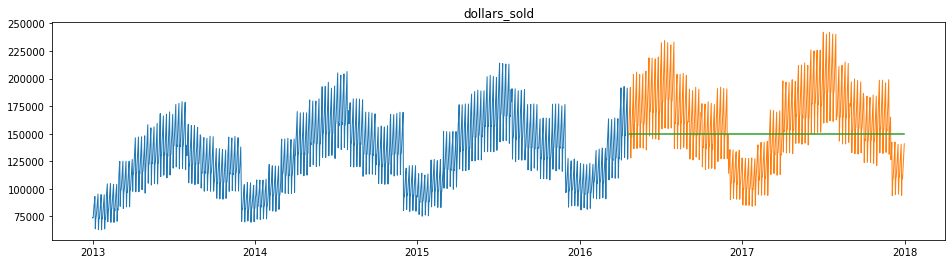

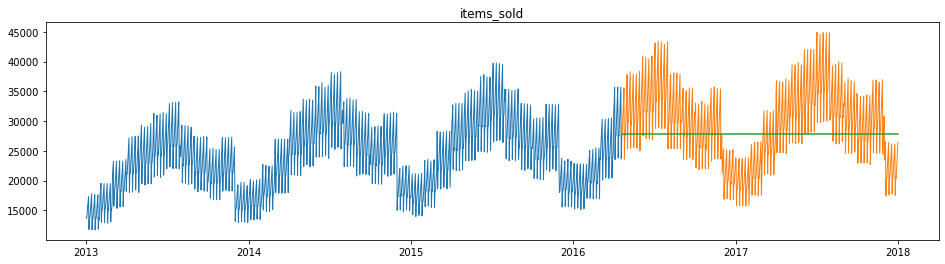

In [11]:
for col in train.columns:
    plt.figure(figsize=(16, 4))
    plt.plot(train[col], label="Train", linewidth=1)
    plt.plot(test[col], label="Test", linewidth=1)
    plt.plot(yhat_df[col])
    plt.title(col)
    plt.show()

**Evaluate**

Compute RMSE

In [12]:
for col in train.columns:
    print(f"{col} = {round(sqrt(mean_squared_error(test[col], yhat_df[col])))}")

dollars_sold = 34906
items_sold = 6521


In [13]:
eval_df = pd.DataFrame(columns = ["model_type", "target_var", "rmse"])

In [14]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(test[target_var], yhat_df[target_var])))
    return rmse

In [15]:
def plot_and_eval(target_var):
    plt.figure(figsize=(16, 4))
    plt.plot(train[target_var], label="Train", linewidth=1)
    plt.plot(test[target_var], label="Test", linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f"-- RMSE: {rmse:.0f}")
    plt.show()

items_sold -- RMSE: 6521


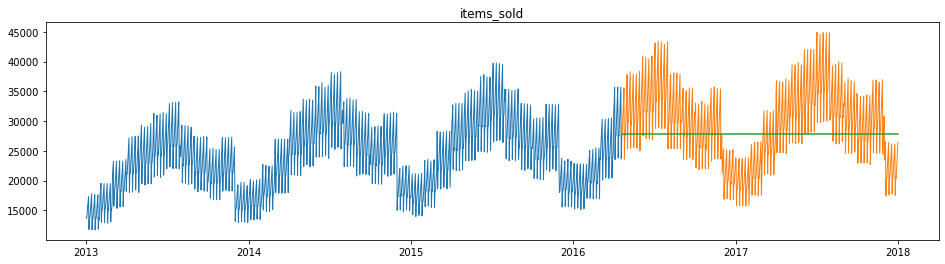

In [16]:
plot_and_eval("items_sold")

In [17]:
eval_df.head()

,model_type,target_var,rmse


In [18]:
# function to store eval rmse for each model
def append_rmse(model_type, target_var):
    rmse = evaluate(target_var)
    d = {"model_type": [model_type], "target_var": [target_var], "rmse": rmse}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index=True)

In [19]:
eval_df = append_rmse("Last Observed Value", target_var="items_sold")
eval_df = append_rmse("Last Observed Value", target_var="dollars_sold")
eval_df

,model_type,target_var,rmse
0,Last Observed Value,items_sold,6521
1,Last Observed Value,dollars_sold,34906


### Simple Average

In [20]:
items = round(train["items_sold"].mean(), 2)
dollars = round(train["dollars_sold"].mean(), 2)

yhat_df = pd.DataFrame({
    "items_sold": items, 
    "dollars_sold": dollars,
}, index=test.index)

In [21]:
yhat_df.head()

,items_sold,dollars_sold
ds,,
2016-04-20 00:00:00+00:00,24225.7,130250.37
2016-04-21 00:00:00+00:00,24225.7,130250.37
2016-04-22 00:00:00+00:00,24225.7,130250.37
2016-04-23 00:00:00+00:00,24225.7,130250.37
2016-04-24 00:00:00+00:00,24225.7,130250.37


**Plot**

dollars_sold -- RMSE: 44784


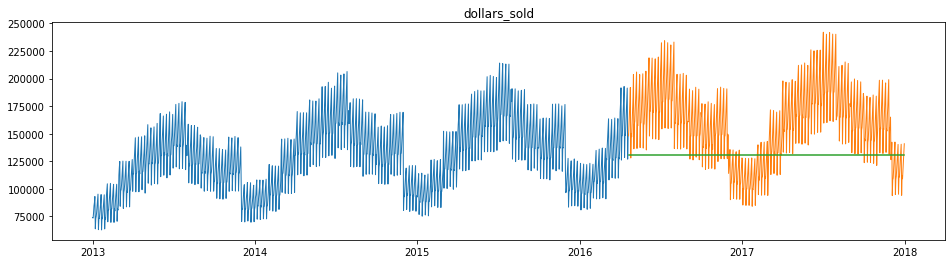

items_sold -- RMSE: 8336


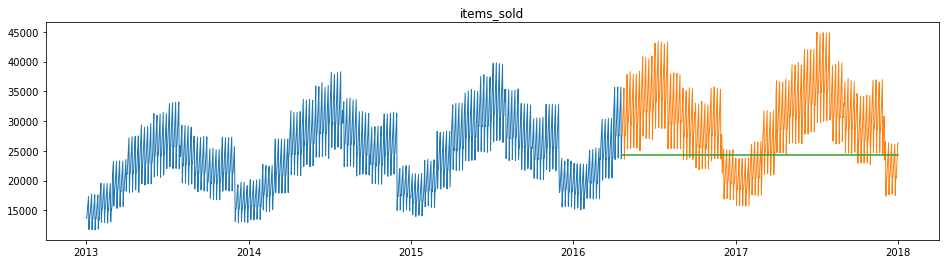

In [22]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

In [23]:
for col in train.columns:
    eval_df = append_rmse(model_type="Simple Average", target_var=col)
    
eval_df

,model_type,target_var,rmse
0,Last Observed Value,items_sold,6521
1,Last Observed Value,dollars_sold,34906
2,Simple Average,dollars_sold,44784
3,Simple Average,items_sold,8336


### Moving Average

In [24]:
period = 30 # for our data that's 30 days

items = round(train["items_sold"].rolling(period).mean().iloc[-1], 2)

dollars = round(train["dollars_sold"].rolling(period).mean().iloc[-1], 2)